Hi Rose,

This code is updated on Mar 31, 2025 upon cross referencing with the file you shared "gemma_3_4b_lora_perfect_results (2).ipynb". Below are my latest findings:

*    I used to use a sliding window approach for the GPT2 models because they had a 1024 token context window restrcition that prevented us from generating a long episode more than 1024 token. This was not changed When I ran Llama and Mistral though the context window for these models was much larger. I found the sliding window apporach largely hindered the models' performance in generating FRIENDS-like episodes in the end. When I used your way to generate new text, my models' performance was instantly better.

*   I modified your way of generating new text a little bit, so that it produces exactly one episode in the end.

*   I added some flexibility to choose what block size to use for the data. We can choose a fixed block size like 2048 or 4096, or use varying-size blocks that were separated by scenes. I added a histogram to show that with this approach, most blocks were under 1000 insize, though some larger blocks can get to about 5000 long.

*   For the varying-size block approach, I chunked the test datasets separately with a fixed block size, this saved time for evaluation. We don't need to split them by scenes anyway since they are test data. I think varying-size blocks take more time because of paddings.

*   Note: the test sets are kept in tokenzied formed because trainer.evaluate() takes ['input_ids'] as the key word. The train and validation sets are kept in text format with the key word ['text'] for SFT Trainer.

*   Don't worry about the generated script's quality in the end in this notebook. For demonstration purposes I just trained the model for 1 step. When you do a proper training the results will be great!

Saber





In [1]:
%%capture
!pip cache purge
!pip install --no-deps accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
!pip install -U bitsandbytes
!pip install datasets
!pip install --no-deps unsloth
!pip install --upgrade unsloth

In [2]:
import torch
import re
from transformers import AutoTokenizer, Trainer, TrainingArguments, DataCollatorForLanguageModeling, AutoModelForCausalLM
from datasets import load_dataset, concatenate_datasets, Dataset, DatasetDict
from peft import LoraConfig, get_peft_model, TaskType
from unsloth import FastLanguageModel
import unsloth
import matplotlib.pyplot as plt

<ipython-input-2-6a670f11a16d>:6: UserWarning: WARNING: Unsloth should be imported before transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# set up model and tokenizer
max_seq_length = 8192
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit
)

==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.50.0.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

In [5]:
# to split the data by scenes
def load_and_split_scenes(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read().strip()
    scenes = re.split(r'(\[Scene:)', text)
    scenes = ["".join(scenes[i:i+2]).strip() for i in range(1, len(scenes), 2)]
    return [scene for scene in scenes if len(scene) > 0]

# load data from Google Drive
data_path = "/content/drive/MyDrive/SEP775NLP_Final_Project/Friends_script/"
train_scenes = load_and_split_scenes(f"{data_path}/cleaned_train_data.txt")
val_scenes = load_and_split_scenes(f"{data_path}/cleaned_val_data.txt")

# create datasets
dataset_dict = DatasetDict({
    "train": Dataset.from_dict({"text": train_scenes}),
    "validation": Dataset.from_dict({"text": val_scenes}),
})

In [6]:
# this function accesses a dataset and tokenize it
def load_and_tokenize(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    tokenized = tokenizer(text)
    return tokenized['input_ids']

test_ids = load_and_tokenize(f"{data_path}/cleaned_test_data.txt")
general_test_ids = load_and_tokenize(f"{data_path}/wikitext103_test.txt")

# create blocks for the test sets
block_size=6144
def create_blocks(all_tokens, block_size):
  blocks = []
  # loop through all of the tokens, split them by block_size
  for i in range(0, len(all_tokens), block_size):
    tokens_in_this_block = all_tokens[i:i+block_size] # takes [0:512], then [512:1024]...
    blocks.append(tokens_in_this_block)
  return blocks # returns a list of list of blocks

# run the function above to create the data blocks
test_blocks = create_blocks(test_ids, block_size=block_size)
general_test_blocks = create_blocks(general_test_ids, block_size=block_size)

# create the Hugging Face dataset dict
test_dataset = Dataset.from_dict({"input_ids": test_blocks})
general_test_dataset = Dataset.from_dict({"input_ids": general_test_blocks})

Longest scene token length explicitly found: 5098


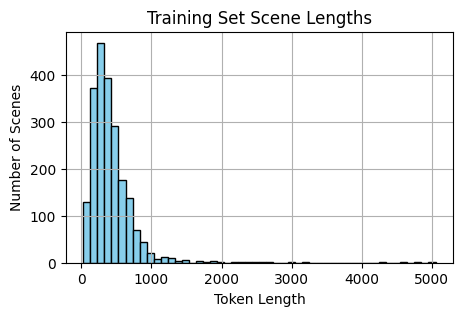

In [8]:
# ensure the maximum length of all scenes is under max_seq_length
def find_max_length(scenes, tokenizer):
    max_length = 0
    for scene in scenes:
        length = len(tokenizer.encode(scene))
        if length > max_length:
            max_length = length
    return max_length

# run the function above and check global maximum
max_train = find_max_length(train_scenes, tokenizer)
max_val = find_max_length(val_scenes, tokenizer)
global_max_length = max(max_train, max_val)
print(f"Longest scene token length explicitly found: {global_max_length}")

# plot a histogram to understand the distribution
def plot_scene_lengths(scenes, tokenizer, title="Scene Length Distribution"):
    lengths = [len(tokenizer.encode(scene)) for scene in scenes]

    plt.figure(figsize=(5, 3))
    plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel("Token Length")
    plt.ylabel("Number of Scenes")
    plt.grid(True)
    plt.show()

plot_scene_lengths(train_scenes, tokenizer, title="Training Set Scene Lengths")
# most scenes in the training data are under 1000 tokens, longest one is around 5000.

In [9]:
# set up LoRA wrapping
model = FastLanguageModel.get_peft_model(
    model,
    r = 32,  # increase for a more powerful adaptation
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    lora_alpha = 32,
    lora_dropout = 0.05,  # Added dropout
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.3.19 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [10]:
from unsloth import is_bfloat16_supported
from trl import SFTTrainer

# set up training arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/SEP775NLP_Final_Project/Models/Llama-8B-Lora",
    evaluation_strategy="steps",
    save_strategy="steps",
    max_steps=1,
    eval_steps=1,
    save_steps=1,
    logging_steps=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps = 8,
    fp16 = not is_bfloat16_supported(),
    bf16 = is_bfloat16_supported(),
    optim = "adamw_8bit",
    learning_rate=1e-4,
    weight_decay=0.01,
    warmup_steps=20,
    lr_scheduler_type="cosine",
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss"
)

# set up SFT Trainer
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset_dict["train"],
    eval_dataset = dataset_dict["validation"],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = True,  # changed to True for efficiency (speeds up short-sequence training)
    args = training_args
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/2172 [00:00<?, ? examples/s]

Unsloth: Hugging Face's packing is currently buggy - we're disabling it for now!


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/258 [00:00<?, ? examples/s]

Unsloth: Hugging Face's packing is currently buggy - we're disabling it for now!


In [11]:
# get initial loss
initial_eval_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Initial loss on Unseen Friends: eval_loss = {initial_eval_results['eval_loss']:.2f}")

initial_general_eval_results = trainer.evaluate(eval_dataset=general_test_dataset)
print(f"Initial loss on WikiText-103: eval_loss = {initial_general_eval_results['eval_loss']:.2f}")

Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Initial loss on Unseen Friends: eval_loss = 2.05
Initial loss on WikiText-103: eval_loss = 1.82


In [12]:
# start training
from unsloth import unsloth_train # use the latest method from unsloth to fix the gradient accumulation issue (https://unsloth.ai/blog/gradient)
trainer_stats = unsloth_train(trainer)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,172 | Num Epochs = 1 | Total steps = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 8 x 1) = 8
 "-____-"     Trainable parameters = 83,886,080/8,000,000,000 (1.05% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss,Model Preparation Time
1,2.277600,2.243434,0.008600


In [13]:
# run final evaluation
eval_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Final loss on Unseen Friends: eval_loss = {eval_results['eval_loss']:.2f}")

general_eval_results = trainer.evaluate(eval_dataset=general_test_dataset)
print(f"Final loss on WikiText-103: eval_loss = {general_eval_results['eval_loss']:.2f}")

Final loss on Unseen Friends: eval_loss = 2.05
Final loss on WikiText-103: eval_loss = 1.82


In [14]:
# generating new scripts
prompt = """
The One with students from McMaster University
Written by: LLaMA-3.1-8B

[Scene: Monica's Apartment. Monica, Ross, Rachel, and Chandler are there.]

Monica: Hey guys! Big news—I heard there's going to be a party at McMaster University.

Ross: A party?

Rachel: Oh yeah! The students are celebrating their SEP775 class with the professors!

Chandler: We should join them! I mean, where is the fun in a party without your favorite FRIENDS characters?

(They all leave for the party.)

[Scene: SEP775 classroom at McMaster University. Rachel, Chandler, Ross, Monica, and Phoebe are hanging out with the students.]

Rachel: Wow, this place kicks ass! Look, isn’t that Professor Mahyar who teaches Natural Language Processing?
"""

inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
outputs = model.generate(
    **inputs,
    max_new_tokens=2500,
    temperature=0.9,
    top_k=50,
    top_p=0.9,
    do_sample=True,
    repetition_penalty=1.1
)
generated_script = tokenizer.decode(outputs[0], skip_special_tokens=True)

# defines a function to chop off everything after one complete episode
def truncate_at_end(text, end_marker=None):
    if end_marker in text:
        return text.split(end_marker)[0].strip()
    return text.strip()

# truncate the genreated script
one_episode = truncate_at_end(generated_script, end_marker="### END OF EPISODE ###")
print(one_episode)

The One with students from McMaster University
Written by: LLaMA-3.1-8B

[Scene: Monica's Apartment. Monica, Ross, Rachel, and Chandler are there.]

Monica: Hey guys! Big news—I heard there's going to be a party at McMaster University.

Ross: A party?

Rachel: Oh yeah! The students are celebrating their SEP775 class with the professors!

Chandler: We should join them! I mean, where is the fun in a party without your favorite FRIENDS characters?

(They all leave for the party.)

[Scene: SEP775 classroom at McMaster University. Rachel, Chandler, Ross, Monica, and Phoebe are hanging out with the students.]

Rachel: Wow, this place kicks ass! Look, isn’t that Professor Mahyar who teaches Natural Language Processing?
Ross: Hey man, do you have any idea about how to build an AI? Do you know what is the latest version of LLaMA?
Professor Mahyar: What is LLaMA?

Phoebe: You know what they say - “Don't mess with the people who can give you free LLMs.” 

(All the students laugh.)
